# makemore1

In [1]:
import torch

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


In [2]:
words = open('names.txt', 'r').read().splitlines()

## Count Approach

In [3]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [5]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        
        N[ix1, ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

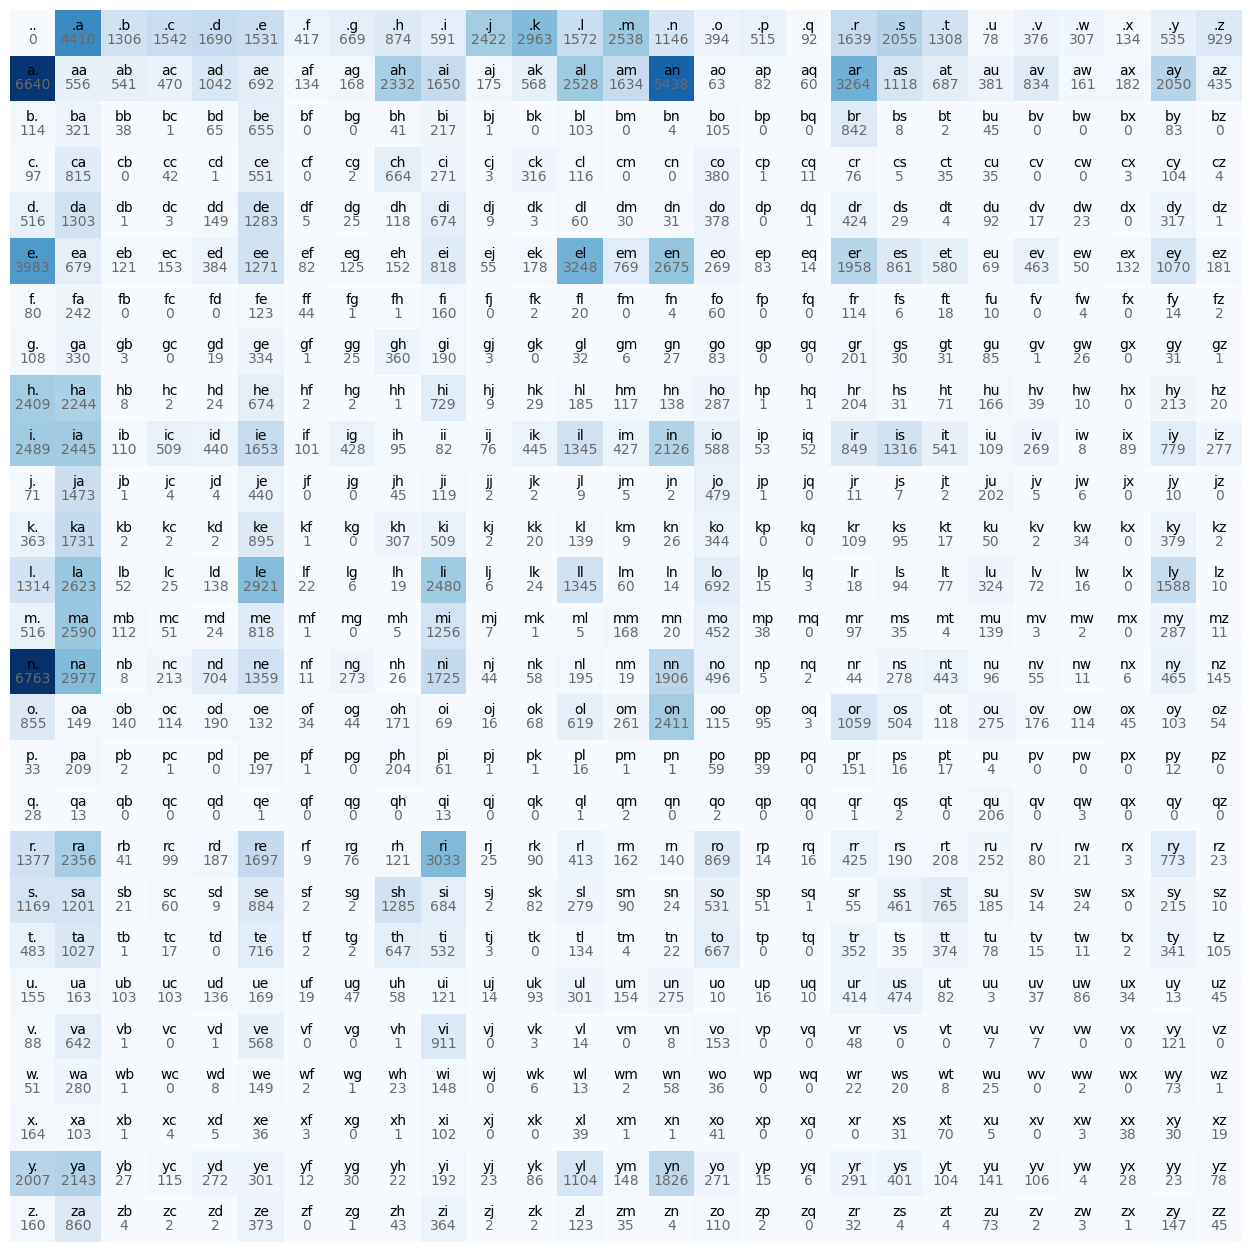

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="black")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="dimgray")
    
plt.axis('off')

In [7]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [8]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [9]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'j'

In [10]:
P = (N+1).float()
P /= P.sum(1, keepdim=True)

In [11]:
P.shape

torch.Size([27, 27])

In [12]:
P.sum(1, keepdim=True).shape

torch.Size([27, 1])

In [13]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
  out = []
  ix = 0
  while True:
      p = P[ix]
      #p = N[ix].float()
      #p = p / p.sum()
      
      ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
      out.append(itos[ix])
      if ix == 0:
          break
  print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.


In [14]:
n = 0
log_lh = 0.0
# test on real string
#for w in ["antonzq"]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_lh += logprob
        n += 1
        #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
        
print(f'{log_lh=}')
nll= - log_lh
print(f'{nll=}')
print(f'{nll/n}')

log_lh=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


## NN Approach

In [15]:
# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [16]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

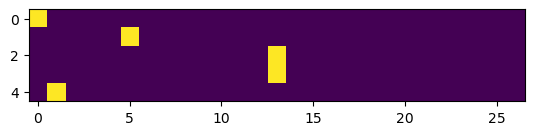

In [17]:
plt.imshow(xenc)

In [18]:
xenc.dtype

torch.float32

In [19]:
W = torch.randn([27, 27])

In [20]:
(xenc @ W) # (5, 27) @ (27, 27) -> (5, 27)
(xenc @ W)[3, 13]

tensor(1.2537)

In [21]:
# same as

In [22]:
xenc[3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
W[:, 13]

tensor([ 0.9346,  0.8507,  0.1178, -0.2135,  0.9790, -0.0371,  1.1400, -0.9357,
        -0.7034, -0.8039, -1.1021, -1.0534, -0.3857,  1.2537,  0.9146, -1.1711,
        -1.9375, -0.9936, -0.1407,  0.0794,  0.2671, -0.0452, -0.6112,  1.1686,
        -0.6354, -0.3353, -0.8199])

In [24]:
(xenc[3] * W[:, 13]).sum()

tensor(1.2537)

In [25]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [26]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # interpret as log counts
counts = logits.exp() # exp to get counts, similar to N
probs = counts / counts.sum(1, keepdims=True) # normalize
loss = -probs[torch.arange(5), ys].log().mean()

In [27]:
probs.shape

torch.Size([5, 27])

In [28]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
       grad_fn=<SelectBackward0>)
label (actual next character): 5
probability assigned by the net to the the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
       grad_fn=<SelectBackward0>)
label (actual next character):

In [29]:
loss.item()

3.7693049907684326

In [30]:
# backwards pass
W.grad = None
loss.backward()

In [31]:
W.data += -0.1 * W.grad

Create NN for real:

In [32]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [33]:
(W**2).sum()

tensor(704.5897, grad_fn=<SumBackward0>)

In [34]:
# gradient descent
for k in range(100):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

3.768618583679199
3.378807306289673
3.161090850830078
3.0271859169006348
2.9344842433929443
2.867231607437134
2.8166542053222656
2.777146339416504
2.745253801345825
2.7188305854797363
2.696505308151245
2.6773722171783447
2.6608052253723145
2.6463515758514404
2.633664846420288
2.622471570968628
2.6125476360321045
2.6037068367004395
2.595794439315796
2.5886809825897217
2.5822560787200928
2.5764293670654297
2.5711236000061035
2.566272735595703
2.5618226528167725
2.5577263832092285
2.5539438724517822
2.550442695617676
2.5471925735473633
2.5441699028015137
2.5413525104522705
2.538721799850464
2.536262273788452
2.5339579582214355
2.531797409057617
2.529768228530884
2.527860164642334
2.5260636806488037
2.5243709087371826
2.522773027420044
2.52126407623291
2.519836902618408
2.5184857845306396
2.5172054767608643
2.5159904956817627
2.5148375034332275
2.5137407779693604
2.51269793510437
2.511704921722412
2.5107579231262207
2.509854793548584
2.5089924335479736
2.5081686973571777
2.507380247116089


In [35]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cfay.
a.
nn.
kohin.
tolian.
juwe.
kalanaauranilevias.
